# Quantum generative adversarial networks

In simple terms, classical generative modelling methods are tasked with learning the transformation between an easy to sample from probability distribution to a harder to sample distribution. While there are a number of methods that perform this action, one popular approach is through [generative adversarial networks](https://dl.acm.org/doi/abs/10.1145/3422622). This method involves sampling from an easy to sample from probability distribution before transforming these samples using a neural network called the *generator*, dependent on parameters $\theta$. A second neural network is used to evaluate these transformed samples called the *discriminator* dependent on parameters $\phi$, which is fed either $S$ samples from the transformed distribution $\{x_1,\dots,x_S\}\sim q_\theta$ or true samples from the target distribution $\{x_1',\dots,x_S'\}\sim p$ and tasked with deciding the source of the samples. It outputs a value $D_\phi$ where $0<D_\phi<1/2$ indicates the samples are drawn from $q_\theta$, and $1/2<D_\phi<1$ indicates the samples were drawn from $p$. The two networks are trained simultaneously by minimizing the generator loss function:

$$ L_G = -\frac{1}{S}\sum^{S}_{i=1}\log D_\phi(x_i), $$

while maximizing the discriminator loss function:

$$ L_D = \frac{1}{S}\sum^{S}_{i=1}\log D_\phi(x_i')+\log (1-D_\phi(x_i)). $$

[Variational quantum algorithms](https://www.nature.com/articles/s42254-021-00348-9) are a popular method proposed for applying noisey intermediate scale quantum devices to problems in areas such as simulation, optimization and quantum machine learning through a hybrid approach. This method involves applying a parameterised quantum circuit (a quantum circuit dependent on a set of tunable classical parameters) to an easy to prepare input state to produce an output state that is measured, and the outcome of this measurement is compared to a desired outcome through a loss function, where the parameterised quantum circuit parameters are adjusted to minimize the loss in future iterations. 

From this alone, it may be apparent to you how variational quantum algorithms can be applied in a generative adversarial network scheme - by replacing the discriminator with a parameterised quantum circuit, and performing measurements on the output state we can produce samples from a distribution which has a form dependent on the tunable parameters $\theta$. This method is named a [quantum generative adversarial network](https://www.nature.com/articles/s41534-019-0223-2) (while there are various methods applied to different problems under the same name).

Here we will be applying a quantum generative adversarial network by adapting a tutorial found [here](https://qiskit.org/ecosystem/machine-learning/tutorials/04_torch_qgan.html) but we will specifically be focused on showing how, with a careful choice of anstaz, this method can be used for preparing a quantum state with desired amplitudes, rather than preparing a quantum state with desired underlying probability distribution.

In [1]:
from qiskit.utils import algorithm_globals
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Sampler
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN
from torch import nn
from torch.optim import Adam
import torch, time, argparse, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
width=0.75
color='black'
fontsize=28
ticksize=22
figsize=(10,10)

First let us define the target probability distribution we wish the output quantum states to approximate:

In [3]:
# For this example, I have chosen a power-law with power -7/3
def targ_prob(xs):
    px = xs**(-7./3)
    return px/np.sum(px)

and let us evaluate this probability distribution over a set range of values and select the number of qubits we wish to discretize the distribution with:

In [4]:
# Set the number of qubits
n = 4
# Number of dimensions (currently hard coded to 1 but can be expanded)
num_dim = 1
# Number of evaluation points
num_discrete_values = 2**n

# Range of x and the intervals between points
xmin, xmax = 40., 168.
dx = (xmax-xmin)/num_discrete_values

# Full set of x values
xs = np.arange(xmin, xmax, dx)
# Evaluate the target distribution over this range
prob_data = targ_prob(xs)

In [5]:
coords = np.linspace(-2, 2, num_discrete_values)
grid_elements = np.expand_dims(coords,axis=1)

We will call upon qiskit's `Sampler` class to create the generator, which inputs the number of samples to generate $S$ as well as the random seed used in the simulation. Note that the result of the training will be highly sensitive to this random seed.

In [6]:
# Set the number of samples S we wish to take from the PQC and target distribution 
shots=10000

# Set the random seed used in the simulation (the outcome is highly sensitive to this)
rseed = 1696004649
# Uncomment line below to change the random seed for the training
#rseed = int(datetime.now().timestamp())
algorithm_globals.random_seed = rseed
_ = torch.manual_seed(rseed) 

# Define the sampler object
sampler = Sampler(options={"shots": shots, "seed": algorithm_globals.random_seed})

Now we can define the form of the parameterised quantum circuit. We choose the ansatz to be that of qiskit's `RealAmplitudes` which takes the $L$ repeating form (where each repitition is called a layer):

$$ \hat{U}(\theta) = \prod_{i=0}^{n-1}\hat{R}_{y}^{(i)}(\theta_{L,i}) \prod_{l=0}^{L-1}\left(\prod_{k=0}^{n-2}\hat{X}^{(k,k+1)}_{C}\prod_{j=0}^{n-1}\hat{R}_{y}^{(j)}(\theta_{l,j})\right), $$

where $\hat{R}_{y}^{i}(\theta_{l,i})$ applies a $y$ rotation gate to qubit $i$ of layer $l$ with an angle of $\theta_{l,i}$ and $\hat{X}^{(k,k+1)}$ applies a controlled NOT gate to qubit $k$ controlled on qubit $k+1$ of the same layer.

By limiting the parameterised quantum circuit to only apply $y$ rotations and $X$ gates, the circuit is limited to rotating around the real part of the Hilbert space (assuming the initial state is also of real amplitudes). 

In [7]:
qc = QuantumCircuit(n)
# Begin by initiallising the qubits in an equal superposition
qc.h(qc.qubits);

# Set the number of layers L
reps = 12

ansatz = RealAmplitudes(n, reps=reps)
qc.compose(ansatz, inplace=True)

We define the generator using qiskit's `SamplerQNN` and pass the ansatz and sampler to this object.

In [8]:
def create_generator() -> TorchConnector:
    qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=[],
        weight_params=qc.parameters,
        sparse=False,
    )

    initial_weights = algorithm_globals.random.random(qc.num_parameters)
    return TorchConnector(qnn, initial_weights) 

We also specify the classical neural network form used as the discriminator using PyTorch's functionality.

In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

These objects we then initialize:

In [10]:
generator = create_generator()
discriminator = Discriminator(num_dim)

The loss function of both the discriminator and generator can be written in the functional form:

In [11]:
def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

Here we define the optimizer used to tune the parameterised quantum circuit given the loss function. Adam gradient decent is chosen with hyperparameters specified here:

In [12]:
lr=0.01
b1=0.7
b2=0.999

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)
discriminator_optimizer = Adam(discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)

Now we can begin the training. We choose the number of epochs (training iterations) and perform the training of both the generator and discriminator simultaneously. During which, we will monitor the loss of both generator and discriminator as well as simulate the output state amplitudes at each step.

This step will likely take minutes-hours to perform, depending on the number of qubits, layers and epochs. 

In [13]:
generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

# Set the number of epochs
n_epochs=1000

num_qnn_outputs = num_discrete_values**num_dim

# Resume training if already performed some iterations
n_epochs = n_epochs-len(entropy_values)
        
start = time.time()
for epoch in tqdm(range(n_epochs)):

    # Define torch target objects
    valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)
    fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)

    # Define torch tensor representing the target probability distribution
    real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)

    # Define torch tensor representing the grid over which samples are taken
    samples = torch.tensor(grid_elements, dtype=torch.float)
    disc_value = discriminator(samples)

    # Generate data
    gen_dist = generator(torch.tensor([])).reshape(-1, 1)

    # Train generator
    generator_optimizer.zero_grad()
    generator_loss = adversarial_loss(disc_value, valid, gen_dist)

    # store for plotting
    generator_loss_values.append(generator_loss.detach().item())

    generator_loss.backward(retain_graph=True)
    generator_optimizer.step()

    # Train Discriminator
    discriminator_optimizer.zero_grad()

    real_loss = adversarial_loss(disc_value, valid, real_dist)
    fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach())
    discriminator_loss = (real_loss + fake_loss) / 2

    # Store for plotting
    discriminator_loss_values.append(discriminator_loss.detach().item())

    discriminator_loss.backward()
    discriminator_optimizer.step()

    # Retreive trained parameters
    with torch.no_grad():
        generated_weights = generator.weight.detach().numpy().reshape((reps+1,n))
    
    # Build circuit to execute given trained parameters
    circ = QuantumCircuit(n)
    circ.h(circ.qubits)

    # Implement parameterised quantum circuit equvalent to RealAmplitude
    for rep in np.arange(reps+1):
        for i in np.arange(n):
            circ.ry(generated_weights[rep,i],circ.qubits[i])
        for i in np.arange(n):
            if i!=n-1 and rep!=reps:
                circ.cx(circ.qubits[i], circ.qubits[i+1])
    
    # Produce resulting state vector
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    state_vector = np.asarray(result.get_statevector())
    
    # Calculate value equivalent to mismatch from fidelity
    entropy_value = 1-np.sqrt(np.abs(np.dot(np.sqrt(prob_data),np.conjugate(state_vector)))**2)
    entropy_values.append(entropy_value)
            
print(np.round(100.*(epoch/n_epochs),2),'%','Mismatch:',"{:.2e}".format(entropy_value),'Generator loss:', np.round(generator_loss_values[-1],2), 'Discriminator loss:', np.round(discriminator_loss_values[-1],2))

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

100%|███████████████████████████████████████| 1000/1000 [06:23<00:00,  2.60it/s]

99.9 % Mismatch: 1.71e-01 Generator loss: 0.76 Discriminator loss: 0.69
Fit in 384.00 sec


Now that is over, lets take a look at the generator and discriminator loss function and mismatch, defined as $1-\sqrt{\mathcal{F}}$, where the fidelity $\mathcal{F}$ is the squared overlap between output and desired states. The loss functions over epochs are shown in the top panel (generator and discriminator loss are black and grey respectively), while the mismatch is shown in the bottom panel. The loss of the discriminator and generator oscilates about a value of $\log(2)$, corresponding to equal performance of the generator and discriminator. When one network outperforms the other, the other must adapt to restore this equilibrium. This provides a drive towards the generator producing a better approximation to the target distribution, and the discriminator to better distinguish the difference. A lower mismatch indicates a higher fidelity approximation of the output state to the target. It should be noted that the generator may perform best at an epoch before the end of the training.

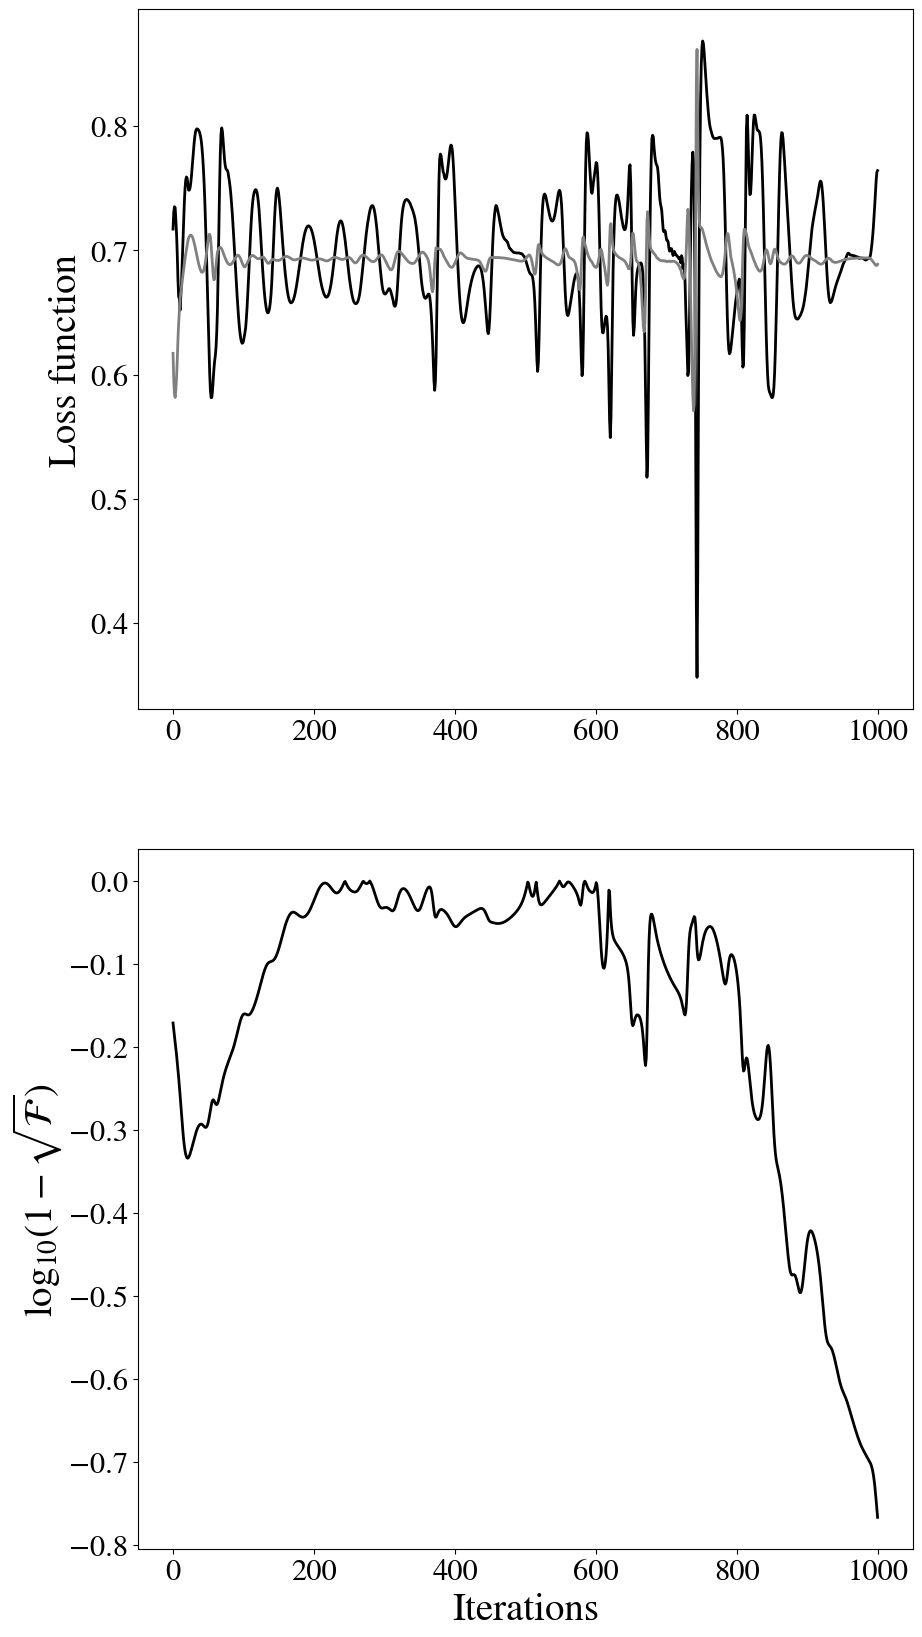

In [14]:
fig = plt.figure(figsize=np.array(figsize)*[1,2])
ax = fig.add_subplot(211)

plt.plot(generator_loss_values, lw=2, color='black')
plt.plot(discriminator_loss_values, lw=2, color='grey')
ax.set_ylabel('Loss function', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

ax = fig.add_subplot(212)

plt.plot(np.log10(entropy_values), lw=2, color='black')
ax.set_ylabel(r'log$_{10}(1-\sqrt{\mathcal{F}})$', fontsize=fontsize);
ax.set_xlabel('Iterations', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

We can also look at the amplitudes of the resulting state after the training. Let us first obtain the weights before specifying the circuit and retreiving the state vector once more:

In [15]:
with torch.no_grad():
    generated_weights = generator.weight.detach().numpy().reshape((reps+1,n))

In [16]:
circ = QuantumCircuit(n)
circ.h(circ.qubits)

for rep in np.arange(reps+1):
    for i in np.arange(n):
        circ.ry(generated_weights[rep,i],circ.qubits[i])
    for i in np.arange(n):
        if i!=n-1 and rep!=reps:
            circ.cx(circ.qubits[i], circ.qubits[i+1])

backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
state_vector = np.asarray(result.get_statevector())

fidelity = np.abs(np.dot(np.sqrt(prob_data),np.conjugate(state_vector)))**2

mismatch = 1. - np.sqrt(fidelity)

print('Fidelity:', fidelity, 'Mismatch:', mismatch)

Fidelity: 0.6873978036510621 Mismatch: 0.17090543141866976


Let us plot a comparison between the generated and target amplitudes, where the solid line shows the generated state amplitude while the target state amplitudes are shown by the dashed line. The bottom shows the difference between the generated and target amplitudes:

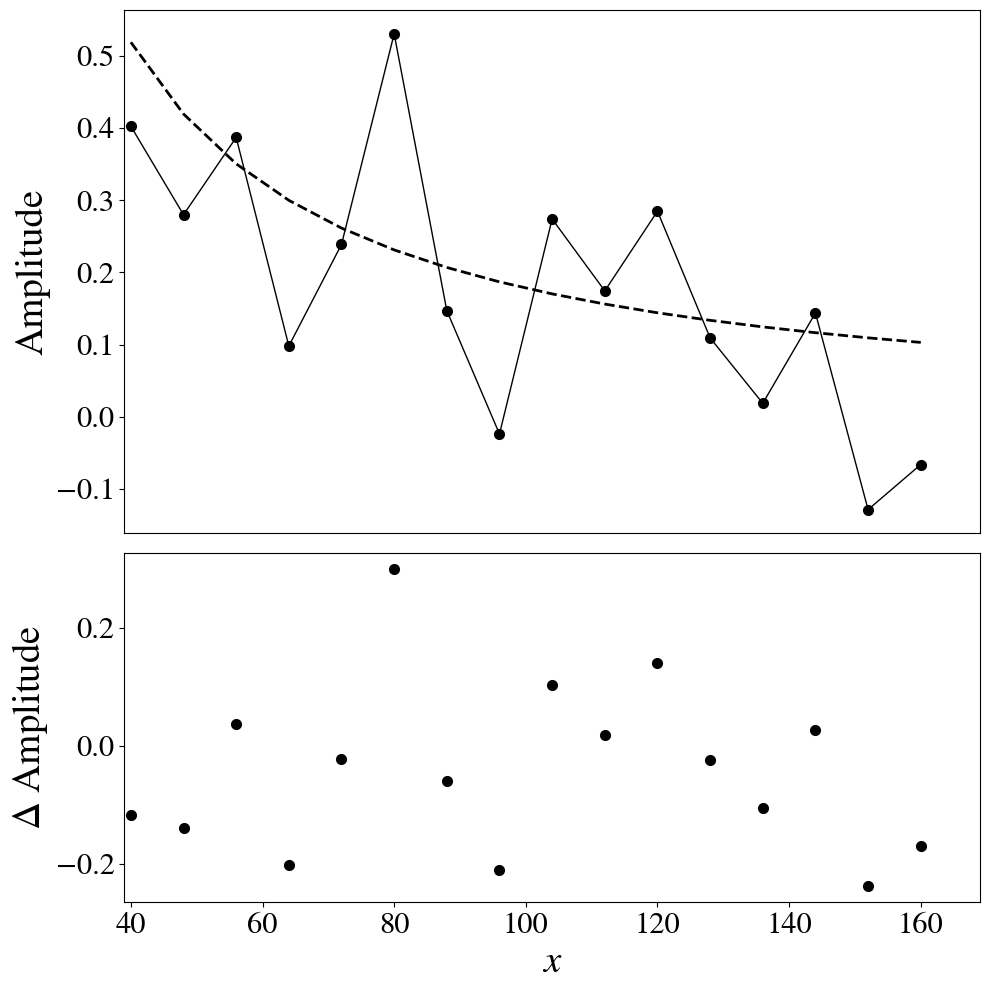

In [17]:
target_state = np.sqrt(targ_prob(xs))

fig, ax = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [1.5, 1]})

color1 = 'black'
color2 = 'grey'

ax[0].scatter(xs, state_vector.real, color=color1, lw=2)
ax[0].plot(xs, state_vector.real, color=color1, ls='-', lw=1)
ax[0].plot(xs, target_state, color=color1, ls='--', lw=2)

ax[0].tick_params(axis='both', labelsize=ticksize)
ax[1].set_xlabel(r'$x$', fontsize=fontsize)
ax[0].set_ylabel(r'Amplitude', fontsize=fontsize)
ax[0].set_xlim(xmin-1,xmax+1)

ax[0].set_xticks([])

ax[1].scatter(xs, state_vector.real-target_state.real, color=color1, lw=2)
ax[1].set_ylabel(r'$\Delta$ Amplitude', fontsize=fontsize)
ax[1].tick_params(axis='both', labelsize=ticksize)
ax[1].set_xlim(xmin-1,xmax+1)

fig.tight_layout()

plt.show()

The closeness between the two is dependent on the training.